In [11]:
import numpy as np
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import LSTM,Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [93]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


### Shape of data

In [92]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (1772, 22, 250, 1)
Training/Valid target shape: (2115,)
Test target shape: (1772, 64, 4, 4)
Person train/valid shape: (2115,)
Person test shape: (443,)


In [34]:
idx = (person_train_valid==0)
idx = np.squeeze(idx)
X_train_valid[idx].shape

(237, 22, 1000)

# Preprocessing

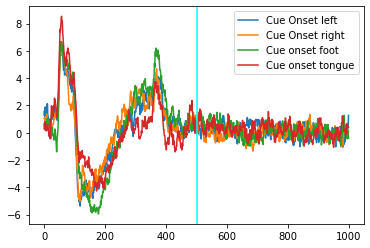

In [99]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.squeeze(np.load("person_train_valid.npy"))
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.squeeze(np.load("person_test.npy"))


## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [5]:
print(person_train_valid.shape)
print(person_test.shape)

(2115,)
(443,)


In [6]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y




In [7]:
X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,20,20,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 25)
Shape of X after averaging+noise and concatenating: (4230, 22, 25)
Shape of X after subsampling and concatenating: (46530, 22, 25)


In [41]:
X_train_valid_prep,person_train_valid_prep = data_prep(X_train_valid,person_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [8]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)





    



Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (15

# Model

In [25]:
# Building the CNN model using sequential class
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_13 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 28, 1, 50)       

# Hyperparameter

In [60]:
# Model parameters
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [61]:
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

In [62]:
basic_cnn_model_results = basic_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=25,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/25
109/109 [==============================] - 3s 25ms/step - loss: 0.3341 - accuracy: 0.8774 - val_loss: 0.8967 - val_accuracy: 0.6813
Epoch 2/25
109/109 [==============================] - 3s 23ms/step - loss: 0.3111 - accuracy: 0.8822 - val_loss: 0.9756 - val_accuracy: 0.6673
Epoch 3/25
109/109 [==============================] - 3s 23ms/step - loss: 0.2965 - accuracy: 0.8884 - val_loss: 0.9689 - val_accuracy: 0.6980
Epoch 4/25
109/109 [==============================] - 3s 24ms/step - loss: 0.3099 - accuracy: 0.8884 - val_loss: 0.8954 - val_accuracy: 0.6880
Epoch 5/25
109/109 [==============================] - 3s 23ms/step - loss: 0.3069 - accuracy: 0.8839 - val_loss: 0.9777 - val_accuracy: 0.7033
Epoch 6/25
109/109 [==============================] - 3s 24ms/step - loss: 0.3122 - accuracy: 0.8825 - val_loss: 0.8834 - val_accuracy: 0.7020
Epoch 7/25
109/109 [==============================] - 3s 25ms/step - loss: 0.2929 - accuracy: 0.8897 - val_loss: 0.9698 - val_accuracy: 0.6827

In [63]:
cnn_score = basic_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7014672756195068


Tune The model

In [81]:
# Building the CNN model using sequential class
tunedcnn = Sequential()

# Conv. block 1
tunedcnn.add(Conv2D(filters=32, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
tunedcnn.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
tunedcnn.add(BatchNormalization())
tunedcnn.add(Dropout(0.5))

# Conv. block 2
tunedcnn.add(Conv2D(filters=64, kernel_size=(10,1), padding='same', activation='elu'))
tunedcnn.add(MaxPooling2D(pool_size=(3,1), padding='same'))
tunedcnn.add(BatchNormalization())
tunedcnn.add(Dropout(0.5))

# Conv. block 3
tunedcnn.add(Conv2D(filters=128, kernel_size=(10,1), padding='same', activation='elu'))
tunedcnn.add(MaxPooling2D(pool_size=(3,1), padding='same'))
tunedcnn.add(BatchNormalization())
tunedcnn.add(Dropout(0.5))

# Conv. block 4
tunedcnn.add(Conv2D(filters=256, kernel_size=(10,1), padding='same', activation='elu'))
tunedcnn.add(MaxPooling2D(pool_size=(3,1), padding='same'))
tunedcnn.add(BatchNormalization())
tunedcnn.add(Dropout(0.5))

# Output layer with Softmax activation
tunedcnn.add(Flatten()) # Flattens the input
tunedcnn.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
tunedcnn.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 32)        7072      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 32)        128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 64)         20544     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 64)        0

In [82]:
tunedcnn.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
tunedcnn_results = tunedcnn.fit(x_train,
             y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/50
109/109 [==============================] - 4s 32ms/step - loss: 1.9837 - accuracy: 0.3109 - val_loss: 2.0210 - val_accuracy: 0.3860
Epoch 2/50
109/109 [==============================] - 3s 31ms/step - loss: 1.4152 - accuracy: 0.3836 - val_loss: 1.4707 - val_accuracy: 0.3620
Epoch 3/50
109/109 [==============================] - 3s 32ms/step - loss: 1.2360 - accuracy: 0.4504 - val_loss: 1.2445 - val_accuracy: 0.4047
Epoch 4/50
109/109 [==============================] - 3s 29ms/step - loss: 1.1575 - accuracy: 0.5022 - val_loss: 1.2536 - val_accuracy: 0.4373
Epoch 5/50
109/109 [==============================] - 3s 28ms/step - loss: 1.0772 - accuracy: 0.5401 - val_loss: 1.0770 - val_accuracy: 0.5707
Epoch 6/50
109/109 [==============================] - 3s 29ms/step - loss: 0.9903 - accuracy: 0.5892 - val_loss: 1.0465 - val_accuracy: 0.5660
Epoch 7/50
109/109 [==============================] - 3s 29ms/step - loss: 0.9314 - accuracy: 0.6157 - val_loss: 1.0455 - val_accuracy: 0.5733

In [84]:
tunedscore = tunedcnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',tunedscore[1])

Test accuracy of the basic CNN model: 0.6760722398757935


In [104]:
keras.backend.clear_session()

# Different datasets


In [100]:
idx = (person_train_valid==0)
idx = np.squeeze(idx)
X_train_valid_p = X_train_valid[idx]
y_train_valid_p = y_train_valid[idx]
y_test

array([1, 0, 2, 3, 3, 2, 2, 3, 3, 0, 2, 3, 2, 0, 1, 1, 3, 3, 2, 0, 2, 1,
       0, 1, 3, 2, 0, 1, 1, 3, 2, 2, 1, 1, 2, 0, 0, 0, 0, 3, 1, 2, 0, 1,
       3, 2, 0, 3, 2, 1, 1, 2, 0, 3, 3, 1, 1, 3, 3, 2, 1, 1, 3, 1, 0, 1,
       1, 1, 2, 0, 0, 1, 3, 2, 2, 0, 1, 2, 0, 2, 3, 2, 0, 1, 3, 0, 0, 3,
       3, 0, 3, 2, 1, 1, 0, 2, 0, 3, 1, 3, 1, 0, 0, 1, 2, 0, 0, 3, 2, 2,
       3, 1, 3, 1, 0, 0, 1, 3, 1, 0, 0, 0, 3, 2, 3, 0, 3, 0, 2, 3, 2, 1,
       3, 1, 1, 3, 0, 1, 3, 0, 0, 2, 2, 0, 2, 3, 3, 1, 0, 3, 0, 3, 1, 2,
       1, 0, 2, 0, 1, 3, 0, 1, 2, 2, 1, 2, 3, 1, 0, 3, 1, 1, 1, 3, 2, 0,
       1, 2, 1, 3, 2, 3, 3, 1, 1, 3, 1, 2, 2, 1, 3, 2, 3, 3, 2, 2, 1, 3,
       2, 1, 3, 1, 0, 0, 3, 2, 0, 0, 0, 3, 3, 2, 0, 1, 0, 2, 0, 0, 3, 2,
       1, 1, 3, 1, 0, 2, 0, 1, 2, 3, 1, 1, 2, 0, 0, 1, 0, 3, 3, 3, 2, 0,
       0, 1, 1, 3, 0, 3, 0, 2, 3, 0, 1, 0, 0, 0, 3, 1, 2, 0, 1, 3, 0, 0,
       2, 3, 3, 2, 1, 0, 0, 3, 2, 2, 3, 1, 1, 3, 2, 0, 1, 0, 0, 2, 1, 2,
       0, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 0,

In [101]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(237, 50, replace=False)
ind_train = np.array(list(set(range(237)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train_p, X_valid_p) = X_train_valid_p[ind_train], X_train_valid_p[ind_valid] 
(y_train_p, y_valid_p) = y_train_valid_p[ind_train], y_train_valid_p[ind_valid]


## Preprocessing the dataset
X_train_p,y_train_p = data_prep(X_train_p,y_train_p,2,2,True)
X_valid_p,y_valid_p = data_prep(X_valid_p,y_valid_p,2,2,True)
## Use whole test set
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)


print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',X_train_p.shape)
print('Shape of validation set:',X_valid_p.shape)
print('Shape of training labels:',y_train_p.shape)
print('Shape of validation labels:',y_valid_p.shape)



# Converting the labels to categorical variables for multiclass classification
y_train_p = to_categorical(y_train_p, 4)
y_valid_p = to_categorical(y_valid_p, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train_p.shape)
print('Shape of validation labels after categorical conversion:',y_valid_p.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
X_train_p = X_train_p.reshape(X_train_p.shape[0], X_train_p.shape[1], X_train_p.shape[2], 1)
X_valid_p = X_valid_p.reshape(X_valid_p.shape[0], X_valid_p.shape[1], X_valid_p.shape[2], 1)
X_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',X_train_p.shape)
print('Shape of validation set after adding width info:',X_valid_p.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
X_train_p = np.swapaxes(X_train_p, 1,3)
X_train_p = np.swapaxes(X_train_p, 1,2)
X_valid_p = np.swapaxes(X_valid_p, 1,3)
X_valid_p = np.swapaxes(X_valid_p, 1,2)
X_test = np.swapaxes(X_test, 1,3)
X_test = np.swapaxes(X_test, 1,2)
print('Shape of training set after dimension reshaping:',X_train_p.shape)
print('Shape of validation set after dimension reshaping:',X_valid_p.shape)
print('Shape of test set after dimension reshaping:',X_test.shape)





    



Shape of X after trimming: (187, 22, 500)
Shape of X after maxpooling: (187, 22, 250)
Shape of X after averaging+noise and concatenating: (374, 22, 250)
Shape of X after subsampling and concatenating: (748, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatenating: (100, 22, 250)
Shape of X after subsampling and concatenating: (200, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of testing set: (1772, 22, 250)
Shape of testing labels: (1772,)
Shape of training set: (748, 22, 250)
Shape of validation set: (200, 22, 250)
Shape of training labels: (748,)
Shape of validation labels: (200,)
Shape of training labels after categorical conversion: (748, 4)
Shape of validation labels after categorical conversion: (200, 4)
Shape 

In [114]:
# Building the CNN model using sequential class
p_cnn_model = Sequential()

# Conv. block 1
p_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
p_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
p_cnn_model.add(BatchNormalization())
p_cnn_model.add(Dropout(0.5))

# Conv. block 2
p_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
p_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
p_cnn_model.add(BatchNormalization())
p_cnn_model.add(Dropout(0.5))

# Conv. block 3
p_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
p_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
p_cnn_model.add(BatchNormalization())
p_cnn_model.add(Dropout(0.5))

# Conv. block 4
p_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
p_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
p_cnn_model.add(BatchNormalization())
p_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
p_cnn_model.add(Flatten()) # Flattens the input
p_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
p_cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 50)        0

In [115]:
p_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
p_cnn_model_results = p_cnn_model.fit(X_train_p,
             y_train_p,
             batch_size=64,
             epochs=25,
             validation_data=(X_valid_p, y_valid_p), verbose=True)

Epoch 1/25
12/12 [==============================] - 1s 39ms/step - loss: 2.5606 - accuracy: 0.3222 - val_loss: 8.6891 - val_accuracy: 0.3350
Epoch 2/25
12/12 [==============================] - 0s 24ms/step - loss: 1.9537 - accuracy: 0.4091 - val_loss: 14.5486 - val_accuracy: 0.4050
Epoch 3/25
12/12 [==============================] - 0s 24ms/step - loss: 1.5508 - accuracy: 0.4545 - val_loss: 20.1632 - val_accuracy: 0.4050
Epoch 4/25
12/12 [==============================] - 0s 26ms/step - loss: 1.2487 - accuracy: 0.5401 - val_loss: 10.3002 - val_accuracy: 0.3650
Epoch 5/25
12/12 [==============================] - 0s 25ms/step - loss: 0.9871 - accuracy: 0.6083 - val_loss: 6.6200 - val_accuracy: 0.4050
Epoch 6/25
12/12 [==============================] - 0s 23ms/step - loss: 0.8333 - accuracy: 0.6644 - val_loss: 6.3666 - val_accuracy: 0.3850
Epoch 7/25
12/12 [==============================] - 0s 28ms/step - loss: 0.6055 - accuracy: 0.7701 - val_loss: 3.8767 - val_accuracy: 0.3800
Epoch 8/25

In [117]:
pscore = p_cnn_model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',pscore[1])

Test accuracy of the basic CNN model: 0.3882618546485901


The overfitting could clearly be observed here

In [118]:
keras.backend.clear_session()

Optimized previously

## Timed

In [25]:
import numpy as np
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import LSTM,Conv2D,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [26]:
learning_rate = 1e-3
epochs = 50
cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [27]:
def data_prep_timed(X,y,sub_sample,average,noise,t):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:t]
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    
    total_X = X_max
    total_y = y
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    return total_X,total_y




In [28]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.squeeze(np.load("person_train_valid.npy"))
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.squeeze(np.load("person_test.npy"))


y_train_valid -= 769
y_test -= 769

In [ ]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

xs_train =[]
xs_valid =[]
xs_test = []
ys_train =[]
ys_valid =[]
ys_test = []
t_list = [200,400,500,600,800,1000]


## Preprocessing the dataset with different time
for t in t_list:
    print(t)
    x_train,y_train = data_prep_timed(X_train,y_train,2,2,True,t)
    x_valid,y_valid = data_prep_timed(X_valid,y_valid,2,2,True,t)
    X_test_prep,y_test_prep = data_prep_timed(X_test,y_test,2,2,True,t)


   



    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)
    
    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    

    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    
    xs_train.append(x_train)
    xs_valid.append(x_valid)
    xs_test.append(x_test)
    ys_train.append(y_train)
    ys_valid.append(y_valid)
    ys_test.append(y_test)




    



Not enough memory to store all data

In [30]:
## Random splitting and reshaping the data
# First generating the training and validation indices using random splitting

ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(Y_train, Y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

tscores = []

Y_test = y_test

In [31]:
t = 200
## Use same train valid split
x_train,y_train = data_prep_timed(X_train,Y_train,2,2,True,t)
x_valid,y_valid = data_prep_timed(X_valid,Y_valid,2,2,True,t)
X_test_prep,y_test_prep = data_prep_timed(X_test,Y_test,2,2,True,t)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

In [32]:
# Building the CNN model using sequential class
t_cnn_model = Sequential()

# Conv. block 1
t_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=x_train.shape[1:4]))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 2
t_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 3
t_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 4
t_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
t_cnn_model.add(Flatten()) # Flattens the input
t_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
t_cnn_model.summary()



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 100, 1, 25)        5525      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 34, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 34, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 34, 1, 25)         0         
                                                                 
 conv2d_17 (Conv2D)          (None, 34, 1, 50)         12550     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 12, 1, 50)       

In [33]:
t_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
t_cnn_model_results = t_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=25,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/25
109/109 [==============================] - 2s 13ms/step - loss: 2.0168 - accuracy: 0.2920 - val_loss: 1.4028 - val_accuracy: 0.3313
Epoch 2/25
109/109 [==============================] - 1s 11ms/step - loss: 1.6333 - accuracy: 0.3122 - val_loss: 1.3231 - val_accuracy: 0.3813
Epoch 3/25
109/109 [==============================] - 1s 11ms/step - loss: 1.4617 - accuracy: 0.3438 - val_loss: 1.3372 - val_accuracy: 0.3640
Epoch 4/25
109/109 [==============================] - 1s 12ms/step - loss: 1.3470 - accuracy: 0.3838 - val_loss: 1.3264 - val_accuracy: 0.4020
Epoch 5/25
109/109 [==============================] - 1s 11ms/step - loss: 1.2751 - accuracy: 0.4297 - val_loss: 1.2471 - val_accuracy: 0.4313
Epoch 6/25
109/109 [==============================] - 1s 11ms/step - loss: 1.2329 - accuracy: 0.4489 - val_loss: 1.1908 - val_accuracy: 0.4680
Epoch 7/25
109/109 [==============================] - 1s 12ms/step - loss: 1.1906 - accuracy: 0.4743 - val_loss: 1.1484 - val_accuracy: 0.4880

In [34]:
tscore = t_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',tscore[1])
tscores.append(tscore[1])

Test accuracy of the basic CNN model: 0.5761851072311401


In [39]:
t = 400
## Use same train valid split
x_train,y_train = data_prep_timed(X_train,Y_train,2,2,True,t)
x_valid,y_valid = data_prep_timed(X_valid,Y_valid,2,2,True,t)
X_test_prep,y_test_prep = data_prep_timed(X_test,Y_test,2,2,True,t)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

# Building the CNN model using sequential class
t_cnn_model = Sequential()

# Conv. block 1
t_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=x_train.shape[1:4]))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 2
t_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 3
t_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 4
t_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
t_cnn_model.add(Flatten()) # Flattens the input
t_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
t_cnn_model.summary()

t_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
t_cnn_model_results = t_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=25,
             validation_data=(x_valid, y_valid), verbose=True)

tscore = t_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',tscore[1])
tscores.append(tscore[1])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 200, 1, 25)        5525      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 67, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 67, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 67, 1, 25)         0         
                                                                 
 conv2d_25 (Conv2D)          (None, 67, 1, 50)         12550     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 23, 1, 50)       

In [41]:
t = 500
## Use same train valid split
x_train,y_train = data_prep_timed(X_train,Y_train,2,2,True,t)
x_valid,y_valid = data_prep_timed(X_valid,Y_valid,2,2,True,t)
X_test_prep,y_test_prep = data_prep_timed(X_test,Y_test,2,2,True,t)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

# Building the CNN model using sequential class
t_cnn_model = Sequential()

# Conv. block 1
t_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=x_train.shape[1:4]))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 2
t_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 3
t_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 4
t_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
t_cnn_model.add(Flatten()) # Flattens the input
t_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
t_cnn_model.summary()

t_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
t_cnn_model_results = t_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=25,
             validation_data=(x_valid, y_valid), verbose=True)

tscore = t_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',tscore[1])
tscores.append(tscore[1])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 84, 1, 25)        0         
 g2D)                                                            
                                                                 
 batch_normalization_28 (Bat  (None, 84, 1, 25)        100       
 chNormalization)                                                
                                                                 
 dropout_28 (Dropout)        (None, 84, 1, 25)         0         
                                                                 
 conv2d_29 (Conv2D)          (None, 84, 1, 50)         12550     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 28, 1, 50)       

In [42]:
t = 600
## Use same train valid split
x_train,y_train = data_prep_timed(X_train,Y_train,2,2,True,t)
x_valid,y_valid = data_prep_timed(X_valid,Y_valid,2,2,True,t)
X_test_prep,y_test_prep = data_prep_timed(X_test,Y_test,2,2,True,t)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

# Building the CNN model using sequential class
t_cnn_model = Sequential()

# Conv. block 1
t_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=x_train.shape[1:4]))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 2
t_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 3
t_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 4
t_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
t_cnn_model.add(Flatten()) # Flattens the input
t_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
t_cnn_model.summary()

t_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
t_cnn_model_results = t_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=25,
             validation_data=(x_valid, y_valid), verbose=True)

tscore = t_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',tscore[1])
tscores.append(tscore[1])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 300, 1, 25)        5525      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 100, 1, 25)       0         
 g2D)                                                            
                                                                 
 batch_normalization_32 (Bat  (None, 100, 1, 25)       100       
 chNormalization)                                                
                                                                 
 dropout_32 (Dropout)        (None, 100, 1, 25)        0         
                                                                 
 conv2d_33 (Conv2D)          (None, 100, 1, 50)        12550     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 34, 1, 50)       

In [43]:
t = 800
## Use same train valid split
x_train,y_train = data_prep_timed(X_train,Y_train,2,2,True,t)
x_valid,y_valid = data_prep_timed(X_valid,Y_valid,2,2,True,t)
X_test_prep,y_test_prep = data_prep_timed(X_test,Y_test,2,2,True,t)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

# Building the CNN model using sequential class
t_cnn_model = Sequential()

# Conv. block 1
t_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=x_train.shape[1:4]))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 2
t_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 3
t_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 4
t_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
t_cnn_model.add(Flatten()) # Flattens the input
t_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
t_cnn_model.summary()

t_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
t_cnn_model_results = t_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=25,
             validation_data=(x_valid, y_valid), verbose=True)

tscore = t_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',tscore[1])
tscores.append(tscore[1])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 400, 1, 25)        5525      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 134, 1, 25)       0         
 g2D)                                                            
                                                                 
 batch_normalization_36 (Bat  (None, 134, 1, 25)       100       
 chNormalization)                                                
                                                                 
 dropout_36 (Dropout)        (None, 134, 1, 25)        0         
                                                                 
 conv2d_37 (Conv2D)          (None, 134, 1, 50)        12550     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 45, 1, 50)       

In [44]:
t = 1000
## Use same train valid split
x_train,y_train = data_prep_timed(X_train,Y_train,2,2,True,t)
x_valid,y_valid = data_prep_timed(X_valid,Y_valid,2,2,True,t)
X_test_prep,y_test_prep = data_prep_timed(X_test,Y_test,2,2,True,t)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)

# Building the CNN model using sequential class
t_cnn_model = Sequential()

# Conv. block 1
t_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu', input_shape=x_train.shape[1:4]))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 2
t_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 3
t_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Conv. block 4
t_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
t_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
t_cnn_model.add(BatchNormalization())
t_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
t_cnn_model.add(Flatten()) # Flattens the input
t_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
t_cnn_model.summary()

t_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
t_cnn_model_results = t_cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=25,
             validation_data=(x_valid, y_valid), verbose=True)

tscore = t_cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',tscore[1])
tscores.append(tscore[1])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 500, 1, 25)        5525      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 167, 1, 25)       0         
 g2D)                                                            
                                                                 
 batch_normalization_40 (Bat  (None, 167, 1, 25)       100       
 chNormalization)                                                
                                                                 
 dropout_40 (Dropout)        (None, 167, 1, 25)        0         
                                                                 
 conv2d_41 (Conv2D)          (None, 167, 1, 50)        12550     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 56, 1, 50)      

In [45]:
tscores

[0.5761851072311401,
 0.6574491858482361,
 0.6625282168388367,
 0.6551918983459473,
 0.6055305004119873,
 0.6523702144622803]

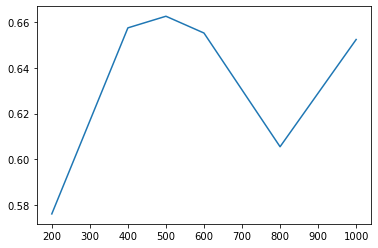

In [47]:
plt.plot([200,400,500,600,800,1000],tscores,)